<h3>Sentiment analysis</h3>

In [14]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import NLP
from matplotlib import pyplot as plt
#import random
#import math
from sklearn import linear_model, metrics, ensemble
import pickle
#from gensim.models.word2vec import Word2Vec
#from gensim.models.doc2vec import Doc2Vec
#from sklearn.manifold import TSNE
#from pyemd import emd
#from gensim import utils
#from gensim.models.doc2vec import LabeledSentence
#from gensim.models import Doc2Vec
from sklearn.decomposition import PCA
import math


In [2]:
# connect to postgresql db
username = 'kimberly'
dbname = 'medium'

dbe = create_engine('postgres://%s@localhost/%s'%(username,dbname))

# get articles df, drop missing data
dfA = pd.read_sql('articles', dbe, index_col='postid')
dfA = dfA.dropna(axis=0,how='any')

dfS = pd.read_sql('sentences', dbe, index_col='level_0')

# add stfidf...
pkl_file = open('stfidf.pkl', 'rb')
stfidf = pickle.load(pkl_file)
pkl_file.close()
dfS['stfidf'] = stfidf

In [3]:
# get startup data

stA = dfA[dfA.tags.str.contains('Startup')]
stS = pd.merge(dfS, stA, how='left', left_on='postid',
         left_index=False, right_index=True)
print(stS.shape)

startup_sentence_bool = ~stS.title.isnull()

stS.drop(stS[stS.title.isnull()].index,inplace=True)
print(stS.shape)

(434792, 21)
(95631, 21)


In [5]:
# add pca on doc2vec as features, and try.
# this NEEDS to be coded by 6 pm.

dfS_raw = pd.read_csv('d2v_array_nostem.csv',index_col='level_0')

print('d2v array loaded')

with open('startup_sentence_bool.pkl','rb') as f:
    startup_sentence_bool = pickle.load(f)

# grab smaller array...
dfS_raw = dfS_raw[startup_sentence_bool]
d2v_array = dfS_raw[dfS_raw.columns[8:]].as_matrix()

# dimensionality reduction
svd = PCA()
svd_transform = svd.fit_transform(d2v_array)
svd_covariance = svd.get_covariance()


d2v array loaded


In [8]:
# add svd_transform first ten columns to the dataset

dfSVD = pd.DataFrame(svd_transform[:,0:10],
                     columns=[['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']],
                     index=stS.index)

stS = pd.concat([stS,dfSVD],axis=1)
                                   

In [10]:
# grab needed columns
stSf = stS[['slabel','alength','sposition','swcount','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']]


In [11]:
# startup articles only
dfS_True = stSf[stSf.slabel==True]
dfS_False = stSf[stSf.slabel==False]
index_file = 'false_indices_startup_exactbal.pkl'

In [12]:
number_true = dfS_True.shape[0]

# re-regenerate or load false_indices
#false_indices = np.random.choice(dfS_False.shape[0], number_false, replace=False)

pkl_file = open(index_file, 'rb')
false_indices = pickle.load(pkl_file)
pkl_file.close()

# save false indices if desired
#output = open('false_indices_exactbal.pkl', 'wb')
#pickle.dump(false_indices, output)
#output.close()

# select samples
dfS_False_dsamp = dfS_False.iloc[false_indices]


In [15]:
# split training and test 80/20

# training data
true_train_indices = np.random.choice(dfS_True.shape[0], 
                                      math.floor(dfS_True.shape[0]*0.8), replace=False)
false_train_indices = np.random.choice(dfS_False_dsamp.shape[0], 
                                       math.floor(dfS_False_dsamp.shape[0]*0.8), replace=False)
dfS_True_train = dfS_True.iloc[true_train_indices]
dfS_False_dsamp_train = dfS_False_dsamp.iloc[false_train_indices]
dfTrain_balanced = pd.concat([dfS_True_train,dfS_False_dsamp_train])
print(dfS_True_train.shape)
print(dfS_False_dsamp_train.shape)
print(dfTrain_balanced.shape)

# test data
true_test_indices = [x for x in range(dfS_True.shape[0]) if x not in true_train_indices]
false_test_indices = [x for x in range(dfS_False_dsamp.shape[0]) if x not in false_train_indices]
dfS_True_test = dfS_True.iloc[true_test_indices]
dfS_False_dsamp_test = dfS_False_dsamp.iloc[false_test_indices]
dfTest_balanced = pd.concat([dfS_True_test,dfS_False_dsamp_test])
print(dfS_True_test.shape)
print(dfS_False_dsamp_test.shape)
print(dfTest_balanced.shape)

(795, 14)
(786, 14)
(1581, 14)
(199, 14)
(197, 14)
(396, 14)


In [16]:
Ytrain = dfTrain_balanced['slabel'].astype('int')
Xtrain = dfTrain_balanced[dfTrain_balanced.columns[1:]]
Ytest = dfTest_balanced['slabel'].astype('int')
Xtest = dfTest_balanced[dfTrain_balanced.columns[1:]]
rfm3 = ensemble.RandomForestClassifier(n_estimators=500, class_weight=None)
rfm3.fit(Xtrain,Ytrain)
print(rfm3.score(Xtrain,Ytrain))
print(rfm3.score(Xtest,Ytest))

1.0
0.618686868687


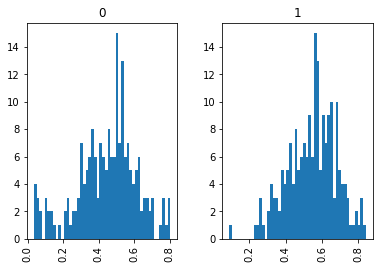

In [17]:
#rfm.predict_proba(Xtrain)
test_predix3 = rfm3.predict_proba(Xtest)[:,1]
test_predix3 = pd.DataFrame(test_predix3,Ytest,columns=['pred'])

plt.figure();
test_predix3.hist(by=test_predix3.index,bins=50)
plt.show()

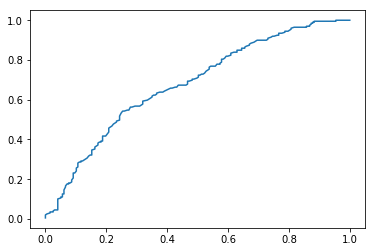

In [25]:
fpr, tpr, thresh = metrics.roc_curve(Ytest, test_predix3)

plt.figure();
plt.plot(fpr,tpr)
plt.show()

<h3>Gradient Boosted Classifiers</h3>

In [22]:
gbt = ensemble.GradientBoostingClassifier(learning_rate=0.3, n_estimators=200, max_depth=6)
gbt.fit(Xtrain,Ytrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

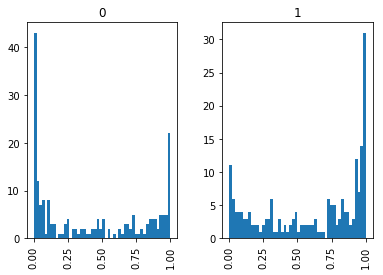

In [23]:
test_predix = gbt.predict_proba(Xtest)[:,1]
test_predix = pd.DataFrame(test_predix,Ytest,columns=['pred'])

plt.figure();
test_predix.hist(by=test_predix.index,bins=50)
plt.show()

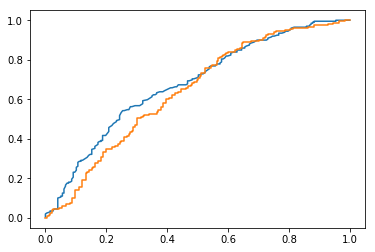

In [26]:
fpr1, tpr1, thresh = metrics.roc_curve(Ytest, test_predix)

plt.figure();
plt.plot(fpr,tpr,fpr1,tpr1)
plt.show()

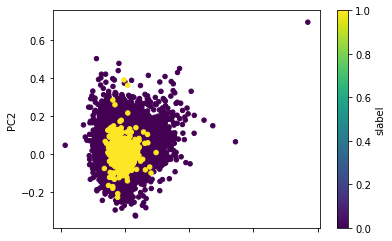

In [29]:
# pca features 1 and 2
stSp = pd.concat([dfS_False,dfS_True],axis=0)

plt.figure();
stSp.plot.scatter(x='PC1',y='PC2',c='slabel',colormap='viridis')
plt.show()

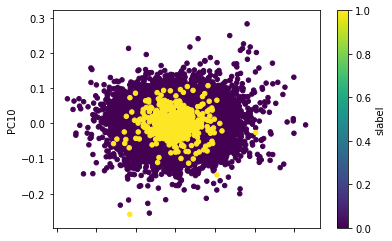

In [33]:
# pca features 1 and 3
stSp = pd.concat([dfS_False,dfS_True],axis=0)

plt.figure();
stSp.plot.scatter(x='PC6',y='PC10',c='slabel',colormap='viridis')
plt.show()